In [15]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time

CIFAR_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

In [16]:
def downloadCIFAR():
    if not os.path.exists('../data'):
        os.system('mkdir ../data')
        print('make dir')
    if not os.path.exists('../data/cifar-10-python.tar.gz'):
        print('downloading CIFAR')
        os.system('wget {}'.format(CIFAR_URL))
        os.system('mv ./cifar-10-python.tar.gz ../data/cifar-10-python.tar.gz')
    else:
        print('CIFAR exist')
    if not os.path.exists('../data/cifar-10-batches-py'):
        print('unpacking CIFAR')
        os.system('tar -zxvf ../data/cifar-10-python.tar.gz -C ../data/')
    else:
        print('CIFAR unpacked')

downloadCIFAR()

downloading CIFAR
CIFAR unpacked


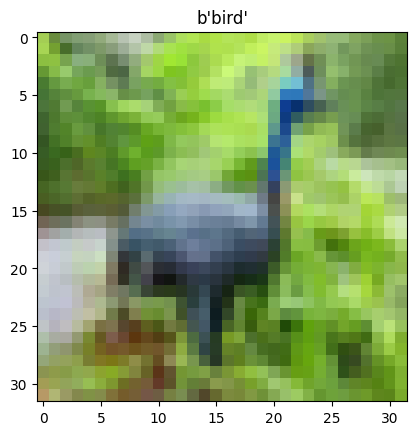

In [17]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def show_img(num):
    dict = unpickle('../data/cifar-10-batches-py/data_batch_1')
    info = unpickle('../data/cifar-10-batches-py/batches.meta')
    np_img = dict[b'data'][num].reshape([3, 32, 32])
    np_img = np_img.transpose(1, 2, 0)
    label = info[b'label_names'][dict[b'labels'][num]]

    plt.imshow(np_img)
    plt.axis('on')
    plt.title(label)
    plt.show()


show_img(6)

In [18]:
def get_label_data(train_val, num=0):
    if train_val == 'train':
        dict = unpickle('../data/cifar-10-batches-py/data_batch_{}'.format(num))
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'],
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)
    else:
        dict = unpickle('../data/cifar-10-batches-py/test_batch')
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'],
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)

def load_data():
    for i in range(5):
        if i == 0:
            train_labels, train_data = get_label_data('train', i + 1)
        else:
            res = get_label_data('train', i + 1)
            train_labels = torch.concat((train_labels, res[0]), dim=0)
            train_data = torch.concat((train_data, res[1]), dim=0)
    test_labels, test_data = get_label_data('test')
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = load_data()
print(train_labels.shape, train_data.shape, test_labels.shape, test_data.shape)

torch.Size([50000]) torch.Size([50000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 3, 32, 32])


In [19]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_data = torch.stack([transform(img) for img in train_data])
test_data = torch.stack([transform(img) for img in test_data])


# 自定义训练

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#定义网络模型
class BasicBlock(nn.Module):  #定义BasicBlock类
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):   #构造函数，初始化对象（输入通道数、输出通道数、步长）
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False) #定义第一个卷积层
        self.bn1 = nn.BatchNorm2d(planes)  #批量归一化层
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) #定义第二个卷积层
        self.bn2 = nn.BatchNorm2d(planes)  #批量归一化层

        self.shortcut = nn.Sequential()  #初始化空顺序容器，实现残差连接
        if stride != 1 or in_planes != self.expansion*planes: #如果步长不为 1 或者输入通道数与输出通道数不匹配，则需要修改 shortcut
            self.shortcut = nn.Sequential( #重新定义 shortcut，包含一个卷积层和一个批量归一化层。
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):  #定义前向传播函数
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):  #定义残差网络模型
    def __init__(self, block, num_blocks, num_classes=10):  #构造函数，（基本块、每个残差层的块数、输出类别数量）
        super(ResNet, self).__init__()
        self.in_planes = 64  #初始化输入通道数

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) #定义卷积层
        self.bn1 = nn.BatchNorm2d(64)  #批量归一化层
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) #定义四个残差层，每个层由多个block组成
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)  #全连接层

    def _make_layer(self, block, planes, num_blocks, stride):  #创建由多个block组成的残差层
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:  #循环创建每个块
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)  #返回包含所有块的顺序容器

    def forward(self, x):  #前向传播
        out = F.relu(self.bn1(self.conv1(x)))  #应用Relu激活函数
        out = self.layer1(out) #依次通过四个残差层
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)  #应用平均池化减小空间维度
        out = out.view(out.size(0), -1)
        out = self.linear(out)  #全连接层
        return out


# 定义ResNet-18
num_blocks = [2, 2, 2, 2]  # ResNet-18的结构
model = ResNet(BasicBlock, num_blocks, num_classes=10)  #实例化网络模型


In [68]:
criterion = nn.CrossEntropyLoss()

In [35]:
# import torch
# import torch.nn.functional as F
# def criterion(outputs, targets):  #定义损失函数
#     # 转换 targets 为 one-hot 编码
#     batch_size = outputs.size(0)   #获取批次大小和类别数
#     num_classes = outputs.size(1)
#     targets_one_hot = torch.zeros(batch_size, num_classes).to(outputs.device)
#     targets_one_hot.scatter_(1, targets.view(-1, 1), 1)

#     # 计算 log-softmax
#     log_probs = F.log_softmax(outputs, dim=1)   #得到每个类别的对数概率

#     # 计算负对数似然损失
#     loss = -torch.sum(log_probs * targets_one_hot, dim=1)
#     loss = torch.mean(loss)

#     return loss   #返回损失值

In [7]:
# class SimpleSGD:    #定义优化器类
#     def __init__(self, params, lr=0.001):   #构造函数，初始化模型参数列表和学习率
#         self.params = list(params)
#         self.lr = lr

#     def zero_grad(self):  #清零参数的梯度
#         for param in self.params:
#             if param.grad is not None:
#                 param.grad.data.zero_()

#     def step(self):   #执行一步参数更新
#         with torch.no_grad():
#             for param in self.params:
#                 if param.grad is not None:
#                     param.data -= self.lr * param.grad.data

In [69]:
# optimizer = SimpleSGD(model.parameters(), lr=0.001)  #定义优化器

In [70]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [71]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def train(model, device, train_loader, optimizer, epoch, criterion): #定义训练函数
    model.train()  #用于训练的模型，设置模型为训练模式
    running_loss = 0.0 #初始化损失和准确率的累计变量
    corrects = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):#遍历数据加载器的每个批次
        data, target = data.to(device), target.to(device) #将数据和标签移动到指定设备
        optimizer.zero_grad() #梯度清空
        output = model(data)  #前向传播得到输出
        loss = criterion(output, target) #计算损失
        loss.backward()  #反向传播计算梯度
        optimizer.step()  #更新模型参数

        # 计算并累计准确率
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += target.size(0)

        running_loss += loss.item() * data.size(0)  #累计损失

        # 只在batch_idx不为0且是100的倍数时打印
        if batch_idx != 0 and batch_idx % 100 == 0:
            avg_loss = running_loss / (batch_idx * data.size(0))  #打印损失和准确率
            acc = 100. * corrects / total
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), avg_loss, acc))
            running_loss = 0.0  #清零。重新累计
            corrects = 0
            total = 0

    return avg_loss, acc

# 假设有CUDA 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  #将模型移动到指定的设备

# 初始化列表来存储每个epoch的损失和准确率
train_losses = []
train_accs = []

# 训练模型
num_epochs = 5  #设置训练轮数

for epoch in range(1, num_epochs + 1): #遍历每个epoch
    avg_loss, acc = train(model, device, DataLoader(TensorDataset(train_data, train_labels), batch_size=64, shuffle=True), optimizer, epoch, criterion)
    train_losses.append(avg_loss) #调用train函数进行训练，获取平均损失和准确率并添加到对应列表
    train_accs.append(acc)

# 保存模型
torch.save(model.state_dict(), 'model.pth')

Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.843563	Acc: 32.61%
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.775608	Acc: 42.47%
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.452717	Acc: 49.77%
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.317131	Acc: 54.44%
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.234188	Acc: 58.11%
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.184367	Acc: 60.20%
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.149384	Acc: 62.98%
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.910730	Acc: 68.13%
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.433537	Acc: 68.94%
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.281522	Acc: 70.20%
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.201256	Acc: 71.95%
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.159432	Acc: 72.33%
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.124074	Acc: 73.66%
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.103693	Acc: 74.31%
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.619467	Acc: 78.60%
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.314132	Acc: 78.77%
Train Epoch

# 尝试绘制loss和acc的图像

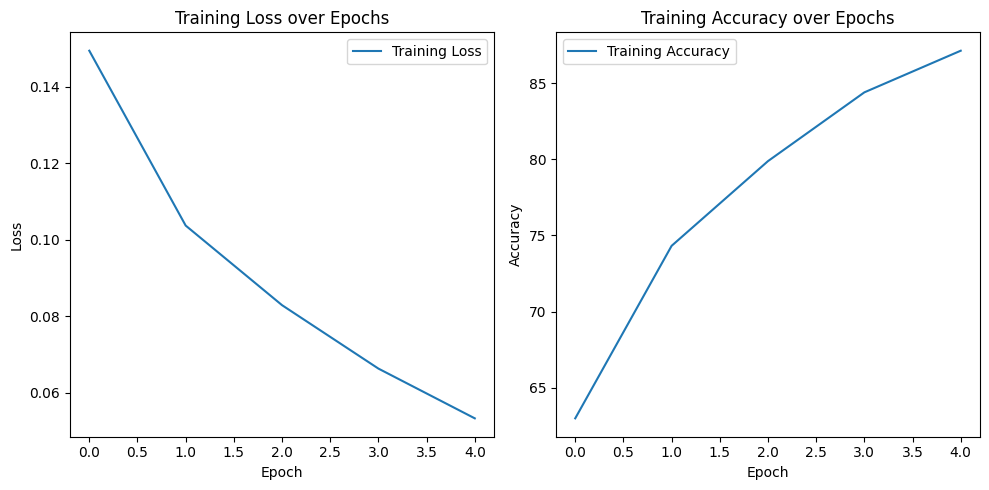

In [72]:
# 确保train_losses和train_accs中的值是CPU张量或数值
train_accs = [acc.item() for acc in train_accs]
# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))  #创建窗口并规定图像大小

# 绘制损失曲线
plt.subplot(1, 2, 1)  #创建子图网格
plt.plot(train_losses, label='Training Loss') #绘制训练损失曲线
plt.title('Training Loss over Epochs') #子图标题
plt.xlabel('Epoch')  #X轴标签
plt.ylabel('Loss')   #Y轴标签
plt.legend()  #显示图例

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()

In [73]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Batch 1: Loss: 0.7356, Accuracy: 78.12%
Batch 2: Loss: 0.3182, Accuracy: 89.06%
Batch 3: Loss: 0.5457, Accuracy: 82.81%
Batch 4: Loss: 0.7761, Accuracy: 78.12%
Batch 5: Loss: 0.5959, Accuracy: 78.12%
Batch 6: Loss: 0.4558, Accuracy: 84.38%
Batch 7: Loss: 0.7563, Accuracy: 78.12%
Batch 8: Loss: 0.4400, Accuracy: 84.38%
Batch 9: Loss: 0.4677, Accuracy: 87.50%
Batch 10: Loss: 0.2333, Accuracy: 90.62%
Batch 11: Loss: 0.5219, Accuracy: 79.69%
Batch 12: Loss: 0.7466, Accuracy: 75.00%
Batch 13: Loss: 0.7433, Accuracy: 70.31%
Batch 14: Loss: 0.9766, Accuracy: 70.31%
Batch 15: Loss: 0.5173, Accuracy: 85.94%
Batch 16: Loss: 0.2855, Accuracy: 89.06%
Batch 17: Loss: 0.7543, Accuracy: 84.38%
Batch 18: Loss: 0.7553, Accuracy: 70.31%
Batch 19: Loss: 0.5168, Accuracy: 84.38%
Batch 20: Loss: 0.7220, Accuracy: 78.12%
Batch 21: Loss: 0.5352, Accuracy: 76.56%
Batch 22: Loss: 0.4719, Accuracy: 87.50%
Batch 23: Loss: 0.4937, Accuracy: 78.12%
Batch 24: Loss: 0.7749, Accuracy: 75.00%
Batch 25: Loss: 0.6090, A

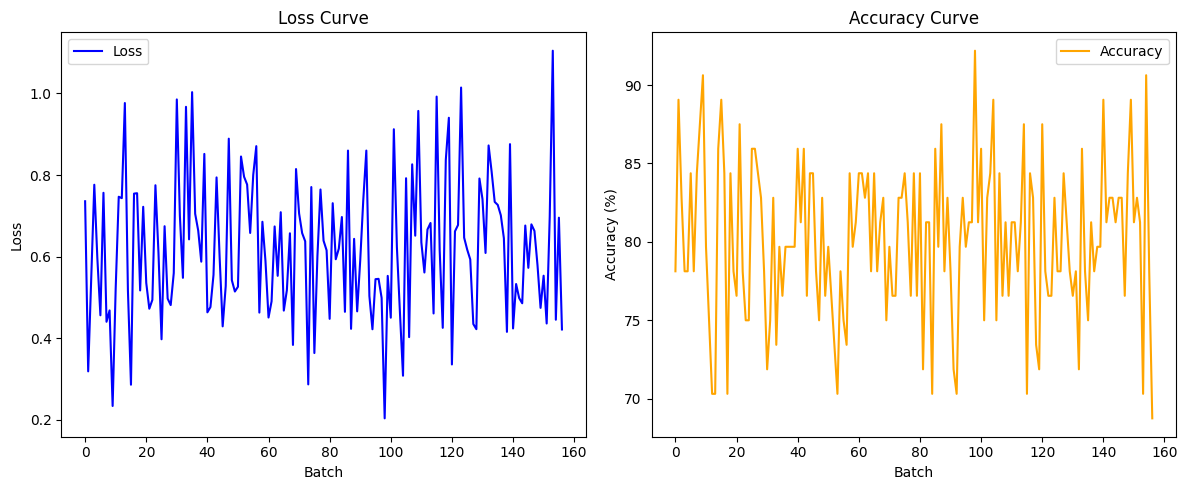

In [74]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

losses1 = []  # 记录每个批次的损失
accuracies1 = []  # 记录每个批次的准确率

def test(model, device, test_loader, output_file):
    model.eval()  # 设置模型为评估模式
    test_loss = 0  # 初始化用于记录测试损失、正确预测数和总样本数的变量
    correct = 0
    total = 0
    preds = []
    
   

    # 记录每个类别的正确预测数和总样本数
    correct_per_class = [0] * 10  # 假设有10个类别
    total_per_class = [0] * 10
    
    with torch.no_grad():  # 不需要计算梯度
        for batch_idx, (data, target) in enumerate(test_loader):  # 遍历每个批次的数据
            data, target = data.to(device), target.to(device)  # 将数据转移到指定设备上
            output = model(data)  # 模型预测得到输出
            loss = criterion(output, target)  # 计算损失
            test_loss += loss.item()  # 累加损失
            
            # 计算批次的准确率
            _, predicted = torch.max(output, 1)  # 获取预测结果
            preds.extend([classes[i] for i in predicted.cpu().numpy()])  # 将预测类别转换为类别标签字符串，并添加到preds列表中
            
            total += target.size(0)  # 累加样本总数
            correct += (predicted == target).sum().item()  # 统计正确预测的样本数

            # 更新每个类别的正确预测数和总样本数
            for i in range(len(target)):
                label = target[i].item()
                correct_per_class[label] += (predicted[i] == target[i]).item()
                total_per_class[label] += 1
            
            # 计算每个批次的损失和准确率
            batch_loss = loss.item()
            batch_accuracy = 100 * (predicted == target).sum().item() / target.size(0)
            losses1.append(batch_loss)
            accuracies1.append(batch_accuracy)
            
            # 打印每个批次的损失和准确率
            print(f'Batch {batch_idx + 1}: Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%')
    
    # 创建DataFrame并保存为CSV文件
    sorted_ids = list(range(1, len(test_data) + 1))
    sorted_ids.sort(key=lambda x: str(x))
    df = pd.DataFrame({'id': sorted_ids, 'label': preds})  # 第一列是id，第二列是预测的类别
    df.to_csv(output_file, index=False)  # 保存为CSV文件，不包含索引

    # 计算平均损失和准确率
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  # 打印平均loss和准确率
        avg_loss, correct, total, accuracy))
    
    # 打印每个类别的准确率
    for i in range(len(correct_per_class)):
        class_accuracy = 100 * correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0
        print(f'Class {i}: Accuracy: {class_accuracy:.2f}%')

    # 绘制损失和准确率曲线
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(losses1, label='Loss', color='blue')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(accuracies1, label='Accuracy', color='orange')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 创建DataLoader
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=64, shuffle=False)

# 创建模型实例并加载训练好的模型
model = ResNet(BasicBlock, num_blocks, num_classes=10)
model.load_state_dict(torch.load('model.pth'))
model.to(device)

# 测试模型并绘制损失和准确率曲线
test(model, device, test_loader, 'submission.csv')


移除残差连接

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#定义网络模型
class BasicBlock(nn.Module):  # 定义一个没有残差连接的卷积块
    def __init__(self, in_planes, planes, stride=1):  # 构造函数
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)  # 定义第一个卷积层
        self.bn1 = nn.BatchNorm2d(planes)  # 批量归一化层
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)  # 定义第二个卷积层
        self.bn2 = nn.BatchNorm2d(planes)  # 批量归一化层

    def forward(self, x):  # 定义前向传播函数
        out = F.relu(self.bn1(self.conv1(x)))  # 应用第一层卷积和ReLU激活
        out = self.bn2(self.conv2(out))  # 应用第二层卷积
        out = F.relu(out)  # 直接应用ReLU激活
        return out

class ResNet(nn.Module):  # 定义没有残差连接的网络模型
    def __init__(self, block, num_blocks, num_classes=10):  # 构造函数
        super(ResNet, self).__init__()
        self.in_planes = 64  # 初始化输入通道数

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 定义卷积层
        self.bn1 = nn.BatchNorm2d(64)  # 批量归一化层
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)  # 定义四个层
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)  # 全连接层

    def _make_layer(self, block, planes, num_blocks, stride):  # 创建由多个块组成的层
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:  # 循环创建每个块
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes  # 更新输入通道数
        return nn.Sequential(*layers)  # 返回包含所有块的顺序容器

    def forward(self, x):  # 前向传播
        out = F.relu(self.bn1(self.conv1(x)))  # 应用 Relu 激活函数
        out = self.layer1(out)  # 依次通过所有层
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)  # 应用平均池化减小空间维度
        out = out.view(out.size(0), -1)
        out = self.linear(out)  # 全连接层
        return out


# 定义ResNet-18使用新的BasicBlock类
num_blocks = [2, 2, 2, 2]  # ResNet-18的结构
model = ResNet(BasicBlock, num_blocks, num_classes=10)  # 实例化网络模型

In [82]:
criterion = nn.CrossEntropyLoss()

In [83]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [84]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def train(model, device, train_loader, optimizer, epoch, criterion): #定义训练函数
    model.train()  #用于训练的模型，设置模型为训练模式
    running_loss = 0.0 #初始化损失和准确率的累计变量
    corrects = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):#遍历数据加载器的每个批次
        data, target = data.to(device), target.to(device) #将数据和标签移动到指定设备
        optimizer.zero_grad() #梯度清空
        output = model(data)  #前向传播得到输出
        loss = criterion(output, target) #计算损失
        loss.backward()  #反向传播计算梯度
        optimizer.step()  #更新模型参数

        # 计算并累计准确率
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += target.size(0)

        running_loss += loss.item() * data.size(0)  #累计损失

        # 只在batch_idx不为0且是100的倍数时打印
        if batch_idx != 0 and batch_idx % 100 == 0:
            avg_loss = running_loss / (batch_idx * data.size(0))  #打印损失和准确率
            acc = 100. * corrects / total
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), avg_loss, acc))
            running_loss = 0.0  #清零。重新累计
            corrects = 0
            total = 0

    return avg_loss, acc

# 假设有CUDA 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  #将模型移动到指定的设备

# 初始化列表来存储每个epoch的损失和准确率
train_losses2 = []
train_accs2 = []

# 训练模型
num_epochs = 5  #设置训练轮数

for epoch in range(1, num_epochs + 1): #遍历每个epoch
    avg_loss, acc = train(model, device, DataLoader(TensorDataset(train_data, train_labels), batch_size=64, shuffle=True), optimizer, epoch, criterion)
    train_losses2.append(avg_loss) #调用train函数进行训练，获取平均损失和准确率并添加到对应列表
    train_accs2.append(acc)

# 保存模型
torch.save(model.state_dict(), 'model2.pth')

Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.944665	Acc: 26.53%
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.841266	Acc: 36.69%
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.522672	Acc: 40.83%
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.382630	Acc: 43.73%
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.277079	Acc: 48.80%
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.228359	Acc: 50.28%
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.185738	Acc: 52.25%
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.177527	Acc: 58.29%
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.550529	Acc: 59.83%
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.367831	Acc: 60.12%
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.259043	Acc: 61.97%
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.210059	Acc: 62.11%
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.167031	Acc: 64.05%
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.138340	Acc: 65.50%
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.904349	Acc: 68.24%
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.443481	Acc: 67.89%
Train Epoch

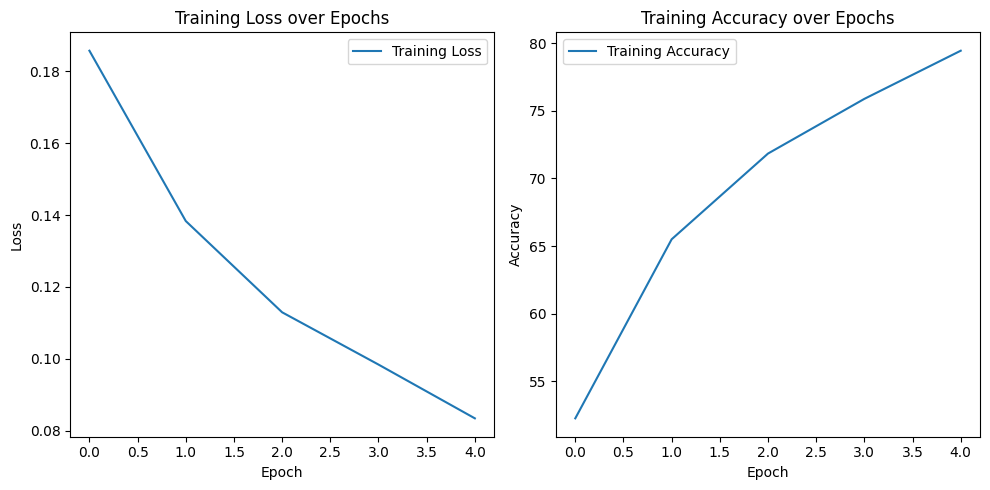

In [85]:
# 确保train_losses和train_accs中的值是CPU张量或数值
train_accs2 = [acc.item() for acc in train_accs2]
# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))  #创建窗口并规定图像大小

# 绘制损失曲线
plt.subplot(1, 2, 1)  #创建子图网格
plt.plot(train_losses2, label='Training Loss') #绘制训练损失曲线
plt.title('Training Loss over Epochs') #子图标题
plt.xlabel('Epoch')  #X轴标签
plt.ylabel('Loss')   #Y轴标签
plt.legend()  #显示图例

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accs2, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()

In [86]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Batch 1: Loss: 0.8324, Accuracy: 65.62%
Batch 2: Loss: 0.6094, Accuracy: 76.56%
Batch 3: Loss: 0.8907, Accuracy: 68.75%
Batch 4: Loss: 0.8004, Accuracy: 75.00%
Batch 5: Loss: 0.7252, Accuracy: 76.56%
Batch 6: Loss: 0.7154, Accuracy: 73.44%
Batch 7: Loss: 0.8196, Accuracy: 68.75%
Batch 8: Loss: 0.7027, Accuracy: 79.69%
Batch 9: Loss: 0.6667, Accuracy: 78.12%
Batch 10: Loss: 0.5477, Accuracy: 81.25%
Batch 11: Loss: 0.8120, Accuracy: 71.88%
Batch 12: Loss: 0.8884, Accuracy: 70.31%
Batch 13: Loss: 0.9687, Accuracy: 60.94%
Batch 14: Loss: 0.8132, Accuracy: 70.31%
Batch 15: Loss: 0.7698, Accuracy: 76.56%
Batch 16: Loss: 0.5432, Accuracy: 78.12%
Batch 17: Loss: 0.8337, Accuracy: 70.31%
Batch 18: Loss: 0.7751, Accuracy: 75.00%
Batch 19: Loss: 0.5783, Accuracy: 84.38%
Batch 20: Loss: 0.9042, Accuracy: 64.06%
Batch 21: Loss: 0.6438, Accuracy: 78.12%
Batch 22: Loss: 0.5946, Accuracy: 76.56%
Batch 23: Loss: 0.7303, Accuracy: 73.44%
Batch 24: Loss: 0.6048, Accuracy: 75.00%
Batch 25: Loss: 0.7391, A

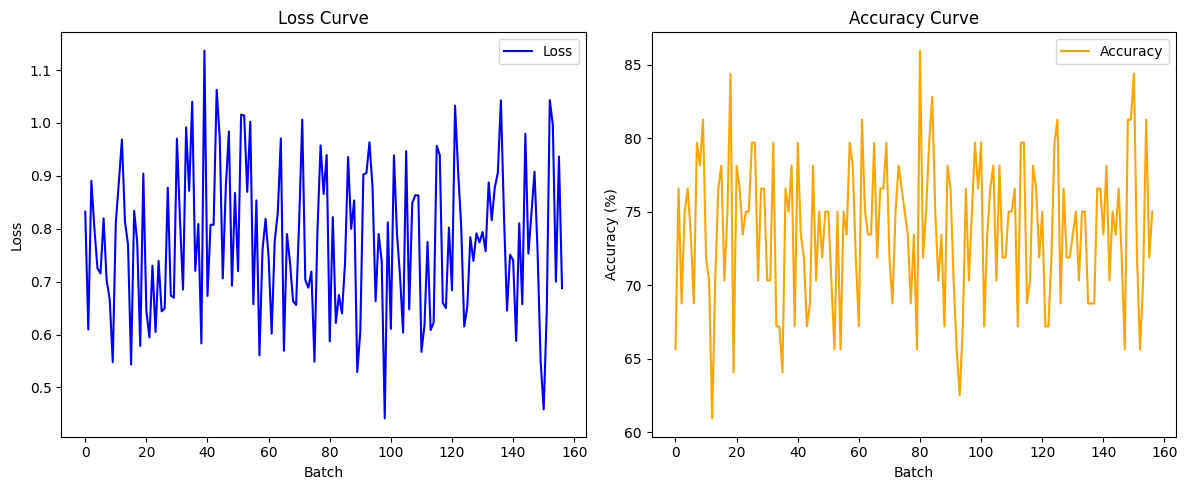

In [87]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

losses2 = []  # 记录每个批次的损失
accuracies2 = []  # 记录每个批次的准确率

def test(model, device, test_loader, output_file):
    model.eval()  # 设置模型为评估模式
    test_loss = 0  # 初始化用于记录测试损失、正确预测数和总样本数的变量
    correct = 0
    total = 0
    preds = []
    
    

    # 记录每个类别的正确预测数和总样本数
    correct_per_class = [0] * 10  # 假设有10个类别
    total_per_class = [0] * 10
    
    with torch.no_grad():  # 不需要计算梯度
        for batch_idx, (data, target) in enumerate(test_loader):  # 遍历每个批次的数据
            data, target = data.to(device), target.to(device)  # 将数据转移到指定设备上
            output = model(data)  # 模型预测得到输出
            loss = criterion(output, target)  # 计算损失
            test_loss += loss.item()  # 累加损失
            
            # 计算批次的准确率
            _, predicted = torch.max(output, 1)  # 获取预测结果
            preds.extend([classes[i] for i in predicted.cpu().numpy()])  # 将预测类别转换为类别标签字符串，并添加到preds列表中
            
            total += target.size(0)  # 累加样本总数
            correct += (predicted == target).sum().item()  # 统计正确预测的样本数

            # 更新每个类别的正确预测数和总样本数
            for i in range(len(target)):
                label = target[i].item()
                correct_per_class[label] += (predicted[i] == target[i]).item()
                total_per_class[label] += 1
            
            # 计算每个批次的损失和准确率
            batch_loss = loss.item()
            batch_accuracy = 100 * (predicted == target).sum().item() / target.size(0)
            losses2.append(batch_loss)
            accuracies2.append(batch_accuracy)
            
            # 打印每个批次的损失和准确率
            print(f'Batch {batch_idx + 1}: Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%')
    
    # 创建DataFrame并保存为CSV文件
    sorted_ids = list(range(1, len(test_data) + 1))
    sorted_ids.sort(key=lambda x: str(x))
    df = pd.DataFrame({'id': sorted_ids, 'label': preds})  # 第一列是id，第二列是预测的类别
    df.to_csv(output_file, index=False)  # 保存为CSV文件，不包含索引

    # 计算平均损失和准确率
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  # 打印平均loss和准确率
        avg_loss, correct, total, accuracy))
    
    # 打印每个类别的准确率
    for i in range(len(correct_per_class)):
        class_accuracy = 100 * correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0
        print(f'Class {i}: Accuracy: {class_accuracy:.2f}%')

    # 绘制损失和准确率曲线
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(losses2, label='Loss', color='blue')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(accuracies2, label='Accuracy', color='orange')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 创建DataLoader
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=64, shuffle=False)

# 创建模型实例并加载训练好的模型
model = ResNet(BasicBlock, num_blocks, num_classes=10)
model.load_state_dict(torch.load('model2.pth'))
model.to(device)

# 测试模型并绘制损失和准确率曲线
test(model, device, test_loader, 'submission2.csv')

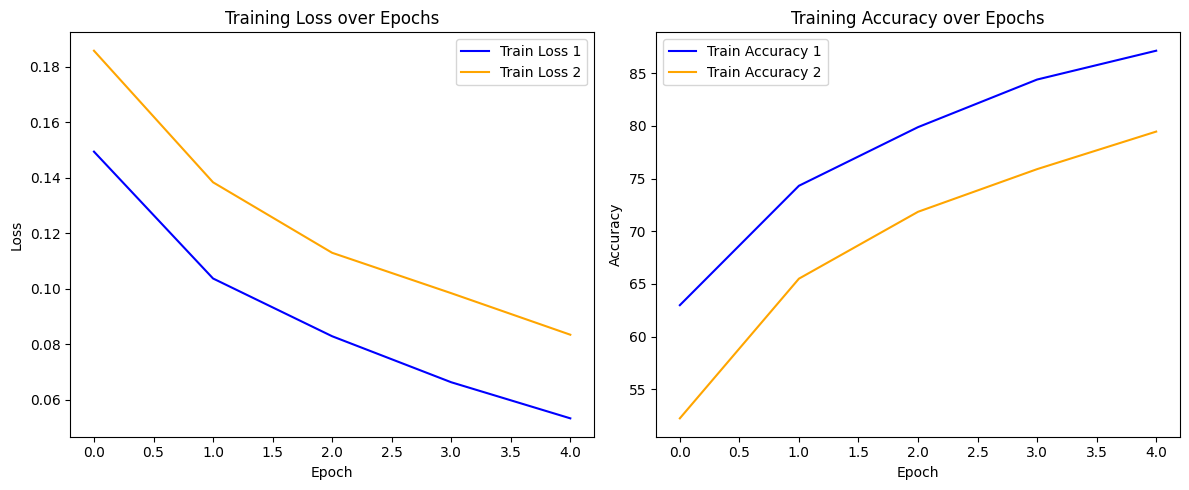

In [88]:
import matplotlib.pyplot as plt

# # 确保train_losses1, train_losses2, train_accs1, train_accs2中的值是CPU张量或数值
# train_losses = [loss.item() for loss in train_losses]
# train_losses2 = [loss.item() for loss in train_losses2]
# train_accs = [acc.item() for acc in train_accs]
# train_accs2 = [acc.item() for acc in train_accs2]

# 训练结束后绘制曲线
plt.figure(figsize=(12, 5))  # 创建窗口并规定图像大小

# 绘制损失曲线
plt.subplot(1, 2, 1)  # 创建子图网格
plt.plot(train_losses, label='Train Loss 1', color='blue')  # 绘制第一组训练损失曲线
plt.plot(train_losses2, label='Train Loss 2', color='orange')  # 绘制第二组训练损失曲线
plt.title('Training Loss over Epochs')  # 子图标题
plt.xlabel('Epoch')  # X轴标签
plt.ylabel('Loss')  # Y轴标签
plt.legend()  # 显示图例

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy 1', color='blue')  # 绘制第一组训练准确率曲线
plt.plot(train_accs2, label='Train Accuracy 2', color='orange')  # 绘制第二组训练准确率曲线
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()


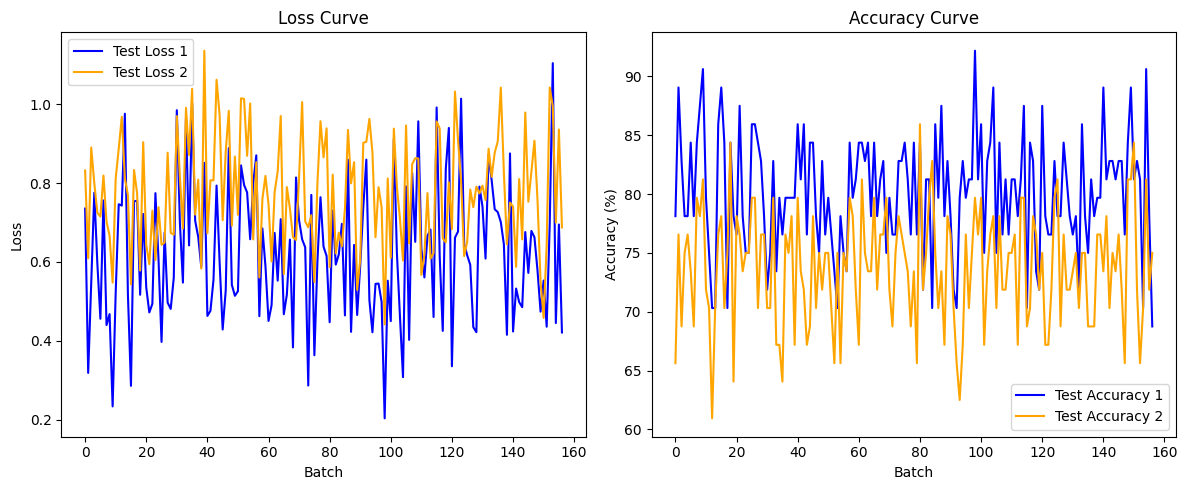

In [89]:
# 绘制损失和准确率曲线
plt.figure(figsize=(12, 5))
    
# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(losses1, label='Test Loss 1', color='blue')  # 绘制第一组训练损失曲线
plt.plot(losses2, label='Test Loss 2', color='orange')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
    
# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(accuracies1, label='Test Accuracy 1', color='blue')
plt.plot(accuracies2, label='Test Accuracy 2', color='orange')
plt.xlabel('Batch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
    
plt.tight_layout()
plt.show()